## 1. Import the libraries and load the dataset

In [57]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [58]:
import os
import torch
import torchvision
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim

In [59]:
# data preprocessing
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Download the dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [60]:
# Split the training dataset into training and validation
size_validset = 10000
size_trainset = len(trainset)-size_validset
train_set, valid_set = random_split(trainset, [size_trainset, size_validset])

trainloader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True, num_workers=2)
validloader = torch.utils.data.DataLoader(valid_set, batch_size=32, shuffle=True, num_workers=2)
# now we have training validation and testing 

In [61]:
print(train_set.dataset.data.shape)
print(len(trainloader.dataset))

(50000, 32, 32, 3)
40000


## Show some of the training images.

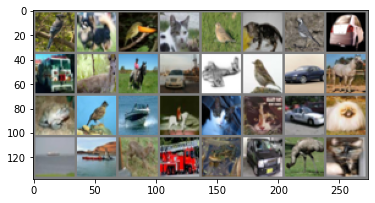

 bird   dog  bird   cat


In [62]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## 2. Define a Convolutional Neural Network
-define a baseline model

In [63]:
# Assuming that we are on a CUDA machine, this should print a CUDA device:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [64]:
def model_baseline():
    
        model = nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),
        nn.Conv2d(32, 16, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),
        nn.Flatten(),
        nn.Linear(16*8*8, 120),
        nn.ReLU(),
        nn.Linear(120, 84),
        nn.ReLU(),
        nn.Linear(84, 10),
        nn.Softmax(1))
    
        return model

#model_baseline = model_baseline()
#print(model_baseline)

In [65]:
# # put the model in the device
# optimizer_baseline = optimizer_baseline.to(device)
#inputs, labels = data[0].to(device), data[1].to(device)

## 3. Train the network

- Build a baseline model for CNN 
- Define a Loss function and optimizer and learning rate
- Build other models for experiment
- use a Classification Cross-Entropy loss and SGD with momentum

In [70]:
def train(epochs, model, optimizer):
    train_loss_ls = []
    train_accuracy_ls = []
    val_loss_ls = []
    val_accuracy_ls = []
    model = model.to(device)
    
    for epoch in range(epochs):  # loop over the dataset multiple times
        '''
        This is the training section
        '''
        training_loss = 0
        training_correct = 0
        model.train() # the model is in training mode, will consider evething like batch normalization and dropout
        
        for i, data in enumerate(trainloader, 0): # each data is one batch
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            predicted = outputs.argmax(1)# index of max probability out of 10 classes

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            training_loss += loss.item()
            training_correct += (predicted == labels).sum().item()

        '''
        This is the validation section
        '''
        val_loss = 0
        val_correct = 0
#         val_total = 0
        model.eval()
        with torch.no_grad(): # do not perform any calculation  
            for data in validloader:
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                predicted = outputs.argmax(1)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
#                 val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

#         print('Val Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

        training_loss = training_loss/(len(trainloader)) # this is consider as batch
        train_acc = (training_correct / len(trainloader.dataset)) # this consider as all simple
        val_loss = val_loss / len(validloader)
        val_acc = (val_correct/len(validloader.dataset))
        
        # save the loss and accuracy in the list
        train_loss_ls.append(training_loss)
        train_accuracy_ls.append(train_acc)
        val_loss_ls.append(val_loss)
        val_accuracy_ls.append(val_acc)
        print("epoch",epoch)
        print("train_accuracy: ",train_acc)
        print("val_accuracy: ",val_acc)

    print('Finished Training')
    return (train_accuracy_ls,train_loss_ls,val_accuracy_ls,val_loss_ls)

In [86]:
def final_train(epochs, model, optimizer):
    train_loss_ls = []
    train_accuracy_ls = []
    test_loss_ls = []
    test_accuracy_ls = []
    model = model.to(device)
    
    for epoch in range(epochs):  # loop over the dataset multiple times
        '''
        This is the training section
        '''
        training_loss = 0
        training_correct = 0
        model.train() # the model is in training mode, will consider evething like batch normalization and dropout
        
        for i, data in enumerate(trainloader, 0): # each data is one batch
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            predicted = outputs.argmax(1)# index of max probability out of 10 classes

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            training_loss += loss.item()
            training_correct += (predicted == labels).sum().item()

        '''
        This is the test section
        '''
        test_loss = 0
        test_correct = 0
#         val_total = 0
        model.eval()
        with torch.no_grad(): # do not perform any calculation  
            for data in testloader:
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                predicted = outputs.argmax(1)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
#                 val_total += labels.size(0)
                test_correct += (predicted == labels).sum().item()

#         print('Val Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

        training_loss = training_loss/(len(trainloader)) # this is consider as batch
        train_acc = (training_correct / len(trainloader.dataset)) # this consider as all simple
        test_loss = test_loss / len(testloader)
        test_acc = (test_correct/len(testloader.dataset))
        
        # save the loss and accuracy in the list
        train_loss_ls.append(training_loss)
        train_accuracy_ls.append(train_acc)
        test_loss_ls.append(test_loss)
        test_accuracy_ls.append(test_acc)
        print("epoch",epoch)
        print("train_accuracy: ",train_acc)
        print("test_accuracy: ",test_acc)

    print('Finished Training')
    return (train_accuracy_ls,train_loss_ls,test_accuracy_ls,test_loss_ls)

In [72]:
# create a function to plot the graph of accuracy and loss 
def plot_graph(train_accuracy_ls,train_loss_ls,val_accuracy_ls,val_loss_ls,epoch):
    # plotting the baseline model
    plt.plot(np.arange(epoch),train_accuracy_ls ,label ="Train accuracy")
    plt.plot(np.arange(epoch),val_accuracy_ls ,label ="Val accuracy")
    plt.plot(np.arange(epoch),train_loss_ls ,label = "train loss")
    plt.plot(np.arange(epoch),val_loss_ls ,label = "val loss")
    plt.title("Training accuracy and loss")
    plt.xlabel("Number of epoch")
    plt.legend()
    plt.show()

In [84]:
# create a function to plot the graph of accuracy and loss 
def plot_graph_final(train_accuracy_ls,test_accuracy_ls,epoch):
    # plotting the baseline model
    plt.plot(np.arange(epoch),train_accuracy_ls ,label ="train accuracy")
    plt.plot(np.arange(epoch),test_accuracy_ls ,label ="test accuracy")
    plt.title("Test accuracy of Model 1")
    plt.xlabel("Number of epoch")
    plt.legend()
    plt.show()

In [73]:
# Define a Loss function and optimizer
# define optimizer with differnt learning rate 0.1, 0.01, 0.001
criterion = nn.CrossEntropyLoss()

model1 = model_baseline()
optimizer_baseline_one = optim.Adam(model1.parameters(), lr=0.1)
results_baseline_one = train(5, model1, optimizer_baseline_one)

model2 = model_baseline()
optimizer_baseline_two = optim.Adam(model2.parameters(), lr=0.01)
results_baseline_two = train(5, model2, optimizer_baseline_two)

model3 = model_baseline()
optimizer_baseline_three = optim.Adam(model3.parameters(), lr=0.001)
results_baseline_three = train(5, model3, optimizer_baseline_three)

epoch 0
train_accuracy:  0.099975
val_accuracy:  0.0998
epoch 1
train_accuracy:  0.10005
val_accuracy:  0.0998
epoch 2
train_accuracy:  0.10005
val_accuracy:  0.0998
epoch 3
train_accuracy:  0.10005
val_accuracy:  0.0998
epoch 4
train_accuracy:  0.10005
val_accuracy:  0.0998
Finished Training
epoch 0
train_accuracy:  0.137775
val_accuracy:  0.1015
epoch 1
train_accuracy:  0.098625
val_accuracy:  0.0965
epoch 2
train_accuracy:  0.09775
val_accuracy:  0.0965
epoch 3
train_accuracy:  0.1002
val_accuracy:  0.0989
epoch 4
train_accuracy:  0.0988
val_accuracy:  0.0989
Finished Training
epoch 0
train_accuracy:  0.353575
val_accuracy:  0.4246
epoch 1
train_accuracy:  0.46495
val_accuracy:  0.466
epoch 2
train_accuracy:  0.505975
val_accuracy:  0.5164
epoch 3
train_accuracy:  0.5394
val_accuracy:  0.5411
epoch 4
train_accuracy:  0.565775
val_accuracy:  0.5537
Finished Training


In [74]:
# from the above experiment, we conclude learning rate = 0.001, give us the best validation accuracy 
# Also, we can see there are improvement for every epochs
# After that, I select the model with the best learning rate and make it into 20 epochs as the final baseline model
model4 = model_baseline()
best_lr_baseline = optim.Adam(model4.parameters(), lr=0.001) # best learning rate baseline
final_baseline = train(20, model4, best_lr_baseline)

epoch 0
train_accuracy:  0.360475
val_accuracy:  0.4664
epoch 1
train_accuracy:  0.4841
val_accuracy:  0.5043
epoch 2
train_accuracy:  0.534725
val_accuracy:  0.56
epoch 3
train_accuracy:  0.570375
val_accuracy:  0.584
epoch 4
train_accuracy:  0.592375
val_accuracy:  0.5925
epoch 5
train_accuracy:  0.611525
val_accuracy:  0.605
epoch 6
train_accuracy:  0.62775
val_accuracy:  0.6006
epoch 7
train_accuracy:  0.645225
val_accuracy:  0.6079
epoch 8
train_accuracy:  0.65455
val_accuracy:  0.6069
epoch 9
train_accuracy:  0.663475
val_accuracy:  0.6109
epoch 10
train_accuracy:  0.6721
val_accuracy:  0.6173
epoch 11
train_accuracy:  0.68035
val_accuracy:  0.6246
epoch 12
train_accuracy:  0.68645
val_accuracy:  0.6364
epoch 13
train_accuracy:  0.6881
val_accuracy:  0.6403
epoch 14
train_accuracy:  0.69925
val_accuracy:  0.6418
epoch 15
train_accuracy:  0.696325
val_accuracy:  0.6278
epoch 16
train_accuracy:  0.706525
val_accuracy:  0.6395
epoch 17
train_accuracy:  0.7078
val_accuracy:  0.6452
e

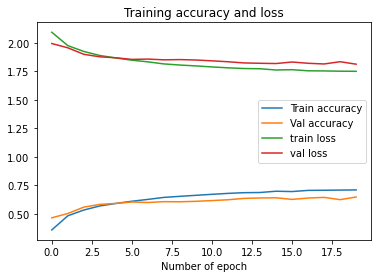

In [75]:
plot_graph(final_baseline[0],final_baseline[1],final_baseline[2],final_baseline[3],20)

In [356]:
# After 20 epochs, we can see the training accuracy and validation accuracy improve,
# train_accuracy:  0.710275, val_accuracy:  0.6253
# It is still acceptable, but we can see when the model train with more epochs, it is more likely to have overfitting
# Therefore, I am going to build second model for experiment
# second model- pure -> normalization -> dropout 
# select the model with the best result

In [76]:
# applied normalization with the baseline modeel
def norm_first_model():
    
        norm_first_model = nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=3, padding=1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),
        nn.Conv2d(32, 16, kernel_size=3, padding=1),
        nn.BatchNorm2d(16),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),
        nn.Flatten(),
        nn.Linear(16*8*8, 120),
        nn.ReLU(),
        nn.Linear(120, 84),
        nn.ReLU(),
        nn.Linear(84, 10),
        nn.Softmax(1))
    
        return norm_first_model

#model_baseline = model_baseline()
#print(model_baseline)

In [36]:
norm_first_model = norm_first_model()
optimizer_norm_first_model = optim.Adam(norm_first_model.parameters(), lr=0.001)
results_norm_first_model = train(20, norm_first_model, optimizer_norm_first_model)

epoch 0
train_accuracy:  0.43125
val_accuracy:  0.5029
epoch 1
train_accuracy:  0.543475
val_accuracy:  0.5251
epoch 2
train_accuracy:  0.5841
val_accuracy:  0.6008
epoch 3
train_accuracy:  0.61525
val_accuracy:  0.574
epoch 4
train_accuracy:  0.638375
val_accuracy:  0.599
epoch 5
train_accuracy:  0.649275
val_accuracy:  0.5916
epoch 6
train_accuracy:  0.661925
val_accuracy:  0.6352
epoch 7
train_accuracy:  0.674675
val_accuracy:  0.6498
epoch 8
train_accuracy:  0.682175
val_accuracy:  0.6385
epoch 9
train_accuracy:  0.6915
val_accuracy:  0.6436
epoch 10
train_accuracy:  0.695625
val_accuracy:  0.6334
epoch 11
train_accuracy:  0.70335
val_accuracy:  0.6541
epoch 12
train_accuracy:  0.709975
val_accuracy:  0.6341
epoch 13
train_accuracy:  0.718
val_accuracy:  0.6705
epoch 14
train_accuracy:  0.725825
val_accuracy:  0.6742
epoch 15
train_accuracy:  0.724975
val_accuracy:  0.6488
epoch 16
train_accuracy:  0.73395
val_accuracy:  0.6728
epoch 17
train_accuracy:  0.738875
val_accuracy:  0.68

In [47]:
# applied normalization with the baseline modeel
def norm_drop_first_model():
    
        norm_drop_first_model = nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=3, padding=1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),
        nn.Conv2d(32, 16, kernel_size=3, padding=1),
        nn.BatchNorm2d(16),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),
        nn.Flatten(),
        nn.Linear(16*8*8, 120),
        nn.Dropout(0.5),
        nn.ReLU(),
        nn.Linear(120, 84),
        nn.ReLU(),
        nn.Linear(84, 10),
        nn.Softmax(1))
    
        return norm_drop_first_model

#model_baseline = model_baseline()
#print(model_baseline)

In [48]:
# train the pure second model without any regularization
norm_drop_first_model = norm_drop_first_model()
optimizer_norm_drop_first_model = optim.Adam(norm_drop_first_model.parameters(), lr=0.001)
results_norm_drop_first_model = train(20, norm_drop_first_model, optimizer_norm_drop_first_model)

epoch 0
train_accuracy:  0.36895
val_accuracy:  0.444
epoch 1
train_accuracy:  0.4615
val_accuracy:  0.5283
epoch 2
train_accuracy:  0.500275
val_accuracy:  0.5559
epoch 3
train_accuracy:  0.52675
val_accuracy:  0.5768
epoch 4
train_accuracy:  0.537775
val_accuracy:  0.5641
epoch 5
train_accuracy:  0.54895
val_accuracy:  0.6009
epoch 6
train_accuracy:  0.5628
val_accuracy:  0.6086
epoch 7
train_accuracy:  0.566525
val_accuracy:  0.5983
epoch 8
train_accuracy:  0.570675
val_accuracy:  0.5898
epoch 9
train_accuracy:  0.58065
val_accuracy:  0.6087
epoch 10
train_accuracy:  0.5807
val_accuracy:  0.6181
epoch 11
train_accuracy:  0.5904
val_accuracy:  0.5916
epoch 12
train_accuracy:  0.58875
val_accuracy:  0.6229
epoch 13
train_accuracy:  0.591725
val_accuracy:  0.6212
epoch 14
train_accuracy:  0.594925
val_accuracy:  0.6148
epoch 15
train_accuracy:  0.599575
val_accuracy:  0.6267
epoch 16
train_accuracy:  0.602125
val_accuracy:  0.5953
epoch 17
train_accuracy:  0.600675
val_accuracy:  0.629

In [55]:
# applied normalization with the baseline modeel
def norm_indrop_first_model():
    
        norm_indrop_first_model = nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=3, padding=1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),
        nn.Conv2d(32, 16, kernel_size=3, padding=1),
        nn.Dropout2d(0.1),
        nn.BatchNorm2d(16),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),
        nn.Flatten(),
        nn.Linear(16*8*8, 120),
        nn.ReLU(),
        nn.Linear(120, 84),
        nn.ReLU(),
        nn.Linear(84, 10),
        nn.Softmax(1))
    
        return norm_indrop_first_model

#model_baseline = model_baseline()
#print(model_baseline)

In [56]:
# train the pure second model without any regularization
norm_indrop_first_model = norm_indrop_first_model()
optimizer_norm_indrop_first_model = optim.Adam(norm_indrop_first_model.parameters(), lr=0.001)
results_norm_indrop_first_model = train(20, norm_indrop_first_model, optimizer_norm_indrop_first_model)

epoch 0
train_accuracy:  0.40565
val_accuracy:  0.5034
epoch 1
train_accuracy:  0.5214
val_accuracy:  0.5585
epoch 2
train_accuracy:  0.560825
val_accuracy:  0.5821
epoch 3
train_accuracy:  0.581575
val_accuracy:  0.5777
epoch 4
train_accuracy:  0.59765
val_accuracy:  0.6055
epoch 5
train_accuracy:  0.610025
val_accuracy:  0.6167
epoch 6
train_accuracy:  0.6206
val_accuracy:  0.6152
epoch 7
train_accuracy:  0.633075
val_accuracy:  0.6264
epoch 8
train_accuracy:  0.638225
val_accuracy:  0.633
epoch 9
train_accuracy:  0.646
val_accuracy:  0.6273
epoch 10
train_accuracy:  0.65255
val_accuracy:  0.6392
epoch 11
train_accuracy:  0.65495
val_accuracy:  0.6184
epoch 12
train_accuracy:  0.662525
val_accuracy:  0.6491
epoch 13
train_accuracy:  0.671525
val_accuracy:  0.6532
epoch 14
train_accuracy:  0.6743
val_accuracy:  0.6259
epoch 15
train_accuracy:  0.67915
val_accuracy:  0.6609
epoch 16
train_accuracy:  0.684225
val_accuracy:  0.6551
epoch 17
train_accuracy:  0.688625
val_accuracy:  0.6594

# 

In [87]:
# test the best baseline model
norm_first_model_final = norm_first_model()
optimizer_norm_first_model_final = optim.Adam(norm_first_model_final.parameters(), lr=0.001)
results_norm_first_model_final = final_train(20, norm_first_model_final, optimizer_norm_first_model_final)

epoch 0
train_accuracy:  0.4136
test_accuracy:  0.4881
epoch 1
train_accuracy:  0.5392
test_accuracy:  0.5567
epoch 2
train_accuracy:  0.5788
test_accuracy:  0.5958
epoch 3
train_accuracy:  0.6099
test_accuracy:  0.6129
epoch 4
train_accuracy:  0.6265
test_accuracy:  0.6232
epoch 5
train_accuracy:  0.6421
test_accuracy:  0.6357
epoch 6
train_accuracy:  0.65535
test_accuracy:  0.6341
epoch 7
train_accuracy:  0.67015
test_accuracy:  0.6486
epoch 8
train_accuracy:  0.672625
test_accuracy:  0.6577
epoch 9
train_accuracy:  0.681975
test_accuracy:  0.6606
epoch 10
train_accuracy:  0.69175
test_accuracy:  0.6599
epoch 11
train_accuracy:  0.700825
test_accuracy:  0.6558
epoch 12
train_accuracy:  0.7026
test_accuracy:  0.6414
epoch 13
train_accuracy:  0.7068
test_accuracy:  0.6652
epoch 14
train_accuracy:  0.7145
test_accuracy:  0.6693
epoch 15
train_accuracy:  0.7227
test_accuracy:  0.6785
epoch 16
train_accuracy:  0.72405
test_accuracy:  0.6715
epoch 17
train_accuracy:  0.73005
test_accuracy:

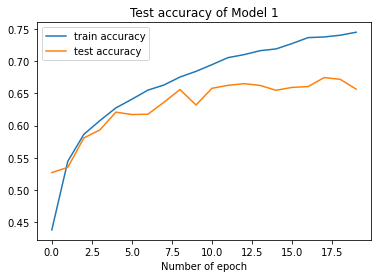

In [85]:
plot_graph_final(results_norm_first_model_final[0],results_norm_first_model_final[2],20)